# Selection Probability Analysis

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pdb
import itertools as it
import scipy.stats as ss
from statsmodels import robust

"""Lexicase Selection Probability"""
def elite(N,k):
    """ return subset of N that is elite on case k"""
    min_fit = min([n.fit[k] for n in N])
    return [n for n in N if n.fit[k] == min_fit]

def lex_prob(N, T, i):
    """computes the probability of an individual being selected.
    N: population with fitness attribute .fit
    T: test cases e.g. [0, 1, 2, 3]
    i: individual whose probability of selection is returned
    """
    if len(N)==1:
        # print("1",end='')
        return 1
    if len(T)==0:
        # print('0',end='')
        return 1/len(N)

    K = elite_cases(i,N,T)
    if not K:
        # print('0',end='')
        return 0

    prob = 0

    # print('1/',len(T),'*(',end='',sep='')

    for q,k_s in enumerate(K):
        # if q>0: print('+',end='')
        T1 = [t for t in T if t!=k_s]
        prob += 1/len(T)*lex_prob(elite(N,k_s),T1,i)

    # print(')',end='')
    return prob

def elite_cases(i,N,T=None):
    """return the cases for which i is elite in N.
    if T provided, calculate eliteness w.r.t. T instead of all the fitness
    values in i.fit.
    """
    min_fit = []
    for t in np.arange(len(i.fit)):
        min_fit.append(min([n.fit[t] for n in N]))
    # pdb.set_trace()
    if T:
        return [x for x,f in enumerate(i.fit) if f == min_fit[x] and x in T]
    else:
        return [x for x,f in enumerate(i.fit) if f == min_fit[x]]

"""epsilon Lexicase Selection Probability"""
def ep_elite(N,k,ep_k):
    """ return subset of N that is elite on case k"""
    min_fit = min([n.fit[k] for n in N])
    return [n for n in N if n.fit[k] <= min_fit+ep_k]

def ep_lex_prob(N, T, i, ep,dynamic=False,printing=False):
    """computes the probability of an individual being selected.
    N: population with fitness attribute .fit
    T: test cases e.g. [0, 1, 2, 3]
    i: individual whose probability of selection is returned
    dynamic: false: semidynamic lexicase (epsilon doesn't change)
             true: dynamic lexicase (epsilon re-calculated among new elites)
    """
    if len(N)==1:
#         if printing: print("1",end='')
        if printing: print('n_'+str(i.id),end='')
        return 1
    if len(T)==0:
#         if printing: print('1/'+str(len(N)),end='')
        if printing: print('{'+ ','.join(['n_'+str(n.id) for n in N]) + '}',end='')
        return 1/len(N)

    K = ep_elite_cases(i,N,ep,T)
#     if printing: print('K:',K)
    if not K:
        if printing: print('0',end='')
        return 0

    prob = 0

#     if printing: print('1/',len(T),'*(',end='',sep='')

    for q,k_s in enumerate(K):
        if printing: 
#             if q>0: print('+',end='')
            print('\n\t-> t_', k_s+1,'[ep=',ep[k_s],',elite= ' +
                  ','.join(['n_'+str(n.id) for n in ep_elite(N,k_s,ep[k_s])]),end='')
        T1 = [t for t in T if t!=k_s]
        if dynamic:
            new_ep = get_eps(ep_elite(N,k_s,ep[k_s]))
            if printing: print('new_ep:',new_ep[k_s],'] (',end='')
#             print('old ep:',ep)
#             print('new ep:', new_ep)
            prob += 1/len(T)*ep_lex_prob(ep_elite(N,k_s,ep[k_s]),T1,i,new_ep,dynamic=True,printing=printing)
        else:   
            prob += 1/len(T)*ep_lex_prob(ep_elite(N,k_s,ep[k_s]),T1,i,ep,printing=printing)

        if printing: print(')')
    return prob

def ep_elite_cases(i,N,ep,T=None):
    """return the cases for which i is elite in N.
    if T provided, calculate eliteness w.r.t. T instead of all the fitness
    values in i.fit.
    """
    min_fit = []
    for t in np.arange(len(i.fit)):
        min_fit.append(min([n.fit[t] for n in N]))
    # pdb.set_trace()
    if T:
        return [x for x,f in enumerate(i.fit) if f <= min_fit[x]+ep[x] and x in T]
    else:
        return [x for x,f in enumerate(i.fit) if f <= min_fit[x]+ep[x]]

def get_eps(N):
    """return epsilon for each case among N"""
    ep = []
    
    for t in np.arange(len(N[0].fit)):
        ep.append(robust.mad(np.array([n.fit[t] for n in N]),c=1))
  
    return ep
   
def ep_convert(N):
    """convert population fitnesses for static epsilon lexicase selection."""
    ep = get_eps(N)
    min_fit = []
    for t in np.arange(len(N[0].fit)):
            min_fit.append(min([n.fit[t] for n in N]))
            
    for n in N:
        for t in np.arange(len(n.fit)): 
            if n.fit[t] <= min_fit[t] + ep[t]:
                n.fit[t] = 0
            else:
                n.fit[t] = 1
                
    return N
"""Tournament Selection Probability"""

def rank(N):
    """ return ranks of N based on fitness"""
    mae = np.empty(len(N))
    for i,n in enumerate(N):
        n.mae = np.mean(n.fit)
        # pdb.set_trace()
        mae[i] = n.mae
    ranks = ss.rankdata(mae)
    # pdb.set_trace()
    for i,n in enumerate(N):
        n.rank = ranks[i]

    return N

def tourn_prob(N, n,t):
    """computes the probability of an individual being selected.
    N: population with fitness attribute .fit
    n: individual whose probability of selection is returned
    t: tournament size
    """
    # get ranks for N, where 1st rank is WORST
    N = rank(N)
#     print('ranks:',[x.rank for x in N])
    Q = [x.rank for x in N]
    # pdb.set_trace()
    # get S, individuals with same rank as n
    S = [s for s in N if s.rank == n.rank]

    as_good = set([q for q in Q if q >= n.rank])
    worse = set([q for q in Q if q > n.rank])
#     print('as_good:',as_good)
#     print('worse:',worse)
    first_term = (np.sum([len([s for s in N if s.rank == i]) for i in as_good])/len(N))**t
    second_term = (np.sum([len([s for s in N if s.rank == i]) for i in worse])/len(N))**t
    # pdb.set_trace()
    # prob = 1 - (1 - (first_term - second_term)/len(S))**len(N)
#     print('first term:',first_term)
#     print('second term:',second_term)
#     print('S:',len(S))
    prob = (first_term-second_term)/len(S)
    # print(')',end='')
    return prob

class ind():
    def __init__(self,id):
        self.fit = []
        self.id = id
        self.rank = None
        self.mae = None

"""Tournament Selection"""
def tournament_selection(N,tourn_size):
    """conducts tournament selection and returns an id"""
    # choose indices from population
    I = np.random.choice(len(N),size=tourn_size)
    # get chosen pool
    pool = [N[i] for i in I]
    # get fitness ranks for chosen pool
    pool = rank(pool)
    ranks = np.array([n.rank for n in pool])
    # return the minimum ranked invidual in the pool
    return pool[np.argmax(ranks)].id
    
"""Lexicase Selection"""
def lexicase_selection(N,T):
    """conducts lexicase selection for de-aggregated fitness vectors"""

    candidates = N
    can_locs = range(len(N))
    cases = list(T)
    np.random.shuffle(cases)
    # pdb.set_trace()
    while len(cases) > 0 and len(candidates) > 1:
        # get best fitness for case among candidates
        best_val_for_case = min([x.fit[cases[0]] for x in candidates])
        # filter individuals without an elite fitness on this case
        candidates,can_locs = zip(*((x,l) for x,l in zip(candidates,can_locs) if x.fit[cases[0]] == best_val_for_case))
        cases.pop(0)

    return candidates[np.random.randint(len(candidates))].id

"""epsilon Lexicase Selection (semi-dynamic)"""
def epsilon_lexicase_selection(N,T,dynamic=False):
    """conducts epsilon lexicase selection for de-aggregated fitness vectors"""

    candidates = N
    can_locs = range(len(N))
    cases = list(T)
    np.random.shuffle(cases)
    
    if not dynamic:
        ep = get_eps(N)
            
    # pdb.set_trace()
    while len(cases) > 0 and len(candidates) > 1:
        # get best fitness for case among candidates
        best_val_for_case = min([x.fit[cases[0]] for x in candidates])
        if dynamic:
            ep = get_eps(candidates)
        # filter individuals without an elite fitness on this case
        candidates,can_locs = zip(*((x,l) for x,l in zip(candidates,can_locs) if x.fit[cases[0]] <= best_val_for_case + ep[cases[0]]))
        cases.pop(0)

    return candidates[np.random.randint(len(candidates))].id

## calculate probability of selection for example

pop:
n_1:	|	 0.0	|	1.1	|	2.2	|	0.0	|	2.0
n_2:	|	 0.1	|	1.2	|	2.0	|	1.0	|	1.0
n_3:	|	 0.2	|	1.0	|	2.1	|	2.0	|	0.0
n_4:	|	 1.0	|	2.1	|	0.2	|	0.0	|	2.0
n_5:	|	 1.1	|	2.2	|	0.0	|	1.0	|	1.0
n_6:	|	 1.2	|	2.0	|	0.1	|	2.0	|	0.0
n_7:	|	 2.0	|	0.1	|	1.2	|	0.0	|	2.0
n_8:	|	 2.1	|	0.2	|	1.0	|	1.0	|	1.0
n_9:	|	 2.2	|	0.0	|	1.1	|	2.0	|	0.0
converted fitnesses
n_1: [ 0.  1.  1.  0.  1.]
n_2: [ 0.  1.  1.  0.  0.]
n_3: [ 0.  1.  1.  1.  0.]
n_4: [ 1.  1.  0.  0.  1.]
n_5: [ 1.  1.  0.  0.  0.]
n_6: [ 1.  1.  0.  1.  0.]
n_7: [ 1.  0.  1.  0.  1.]
n_8: [ 1.  0.  1.  0.  0.]
n_9: [ 1.  0.  1.  1.  0.]
epsilons: [0.90000000000000013, 0.90000000000000013, 0.90000000000000013, 1.0, 1.0]
Pr	|	tourn	|	lex	|	$\epsilon$ lex static	|	$\epsilon$ lex semi	|	$\epsilon$ lex dyn
n_1	|	0.111	|	0.267	|	0.000	|	0.083	|	0.033
n_2	|	0.111	|	0.000	|	0.333	|	0.167	|	0.183
n_3	|	0.111	|	0.067	|	0.000	|	0.083	|	0.117
n_4	|	0.111	|	0.067	|	0.000	|	0.083	|	0.150
n_5	|	0.111	|	0.200	|	0.333	|	0.167	|	0.133
n_6	|	0.111	|	0.067	

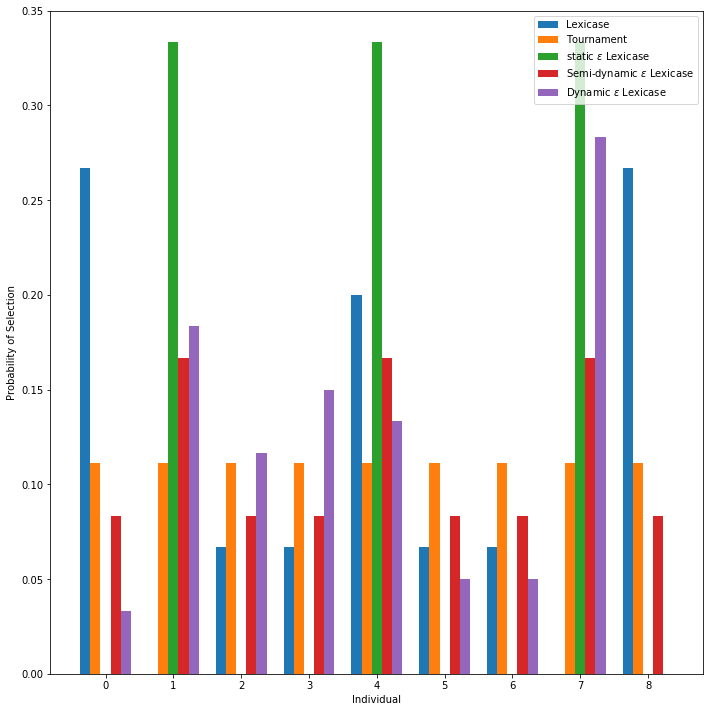

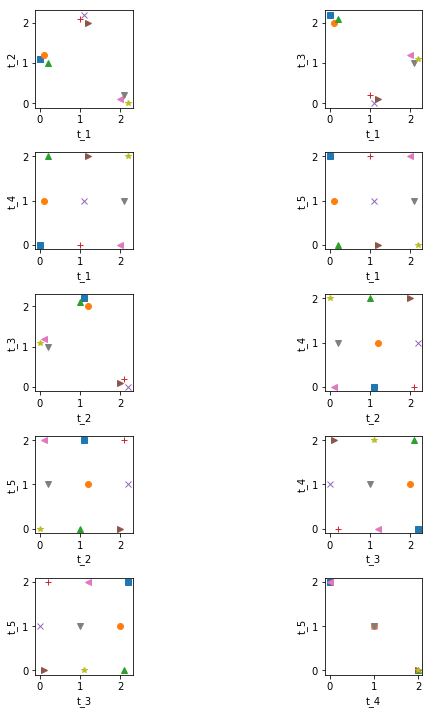

In [288]:
#calculate probability of selection for example"""
import copy
P = 9
pop = []
for i in range(P):
    pop.append(ind(i+1))

total_passes=np.empty(P)

# define fitness values
# lee's paper
# pop[0].fit = np.array([2.0, 2.0, 4.0, 2.0])
# pop[1].fit = np.array([1.0, 2.0, 4.0, 3.0])
# pop[2].fit = np.array([2.0, 2.0, 3.0, 4.0])
# pop[3].fit = np.array([0.0, 2.0, 5.0, 5.0])
# pop[4].fit = np.array([0.0, 3.0, 5.0, 2.0])
# pop[0].fit = np.array([2.01, 1.99, 4, 2])
# pop[1].fit = np.array([1, 1.99, 4, 3])
# pop[2].fit = np.array([2, 2, 3, 4])
# pop[3].fit = np.array([0, 1.9, 5, 5])
# pop[4].fit = np.array([0.01, 3, 5, 1.99])
# my example
pop[0].fit = np.array([0.0, 1.1, 2.2, 0, 8])
pop[1].fit = np.array([0.1, 1.2, 2.0, 1, 7])
pop[2].fit = np.array([0.2, 1.0, 2.1, 2, 6])
pop[3].fit = np.array([1.0, 2.1, 0.2, 3, 5])
pop[4].fit = np.array([1.1, 2.2, 0.0, 4, 4])
pop[5].fit = np.array([1.2, 2.0, 0.1, 5, 3])
pop[6].fit = np.array([2.0, 0.1, 1.2, 6, 2])
pop[7].fit = np.array([2.1, 0.2, 1.0, 7, 1])
pop[8].fit = np.array([2.2, 0.0, 1.1, 8, 0])

#lee's paper with floating point edits
# pop[0].fit = np.array([2.1, 2.0, 4.1, 2.0])
# pop[1].fit = np.array([1.0, 2.1, 4.0, 3.0])
# pop[2].fit = np.array([2.0, 1.9, 3.0, 4.0])
# pop[3].fit = np.array([0.1, 2.2, 5.1, 5.0])
# pop[4].fit = np.array([0.0, 3.0, 5.0, 2.1])

# tozier's examples ##
# #population
# pop[0].fit = np.array([1, 2, 3, 4, 5, 6, 7, 8])
# pop[1].fit = np.array([2, 3, 4, 5, 6, 7, 9, 1])
# pop[2].fit = np.array([2, 5, 4, 5, 6, 7, 9, 1])
# pop[3].fit = np.array([7, 1, 7, 8, 9, 1, 1, 4])
# pop[4].fit = np.array([4, 4, 4, 4, 4, 4, 4, 4])
#boring
# pop[0].fit = np.array([2, 2, 3, 4, 5, 6, 7, 8])
# pop[1].fit = np.array([3 ,2, 3, 4, 5, 6, 7, 8])
# pop[2].fit = np.array([1 ,2, 3, 4, 5, 6, 7, 8])
# pop[3].fit = np.array([1 ,3, 3, 4, 5, 6, 7, 8])
# pop[4].fit = np.array([1 ,2, 4, 4, 5, 6, 7, 8])
# #simple
# pop[0].fit = np.array([1, 2, 3])
# pop[1].fit = np.array([2, 3, 1])
# pop[2].fit = np.array([3, 1, 2])
# #identical
# pop[0].fit = np.array([1, 1, 1])
# pop[1].fit = np.array([1, 1, 1])
# pop[2].fit = np.array([1, 1, 1])
# print population
print('pop:')

for i,n in enumerate(pop):
    print('n_'+str(i+1)+':\t|\t','\t|\t'.join(['{:1.1f}'.format(f) for f in n.fit]))
    
# training cases
T = range(len(pop[0].fit))
N2 = ep_convert(copy.deepcopy(pop))
print('converted fitnesses')
for i,n in enumerate(N2):
    print('n_'+str(i+1)+':',n.fit)
# epsilon
# ep = get_eps(pop)
print("epsilons:",get_eps(pop))
# eliteness vec
tot = 0
tot_l = 0
tot_e  = 0
tot_ed = 0
print('Pr','|','tourn','|','lex','|','$\epsilon$ lex static','|','$\epsilon$ lex semi', '|','$\epsilon$ lex dyn',sep='\t')
# print("--")
Psel_lex, Psel_t, Psel_eplex_static, Psel_eplex_semi, Psel_eplex_dyn = [],[],[],[],[]
for i,(p,p2) in enumerate(zip(pop,N2)):
    

    Psel_lex.append(lex_prob(pop,T,p))
    
    Psel_t.append(tourn_prob(pop,p,2))
    
    Psel_eplex_static.append(lex_prob(N2,T,p2))
    
    Psel_eplex_semi.append(ep_lex_prob(pop,T,p,get_eps(pop)))
#     print('n_'+str(i+1),':')
    if i == 2:
        Psel_eplex_dyn.append(ep_lex_prob(pop,T,p,get_eps(pop),dynamic=True,printing=False))
    else:
        Psel_eplex_dyn.append(ep_lex_prob(pop,T,p,get_eps(pop),dynamic=True))
#     print('\n')
    
    
    print("n_" + str(i+1) + "\t|\t{:1.3f}\t|\t{:1.3f}\t|\t{:1.3f}\t|\t{:1.3f}\t|\t{:1.3f}".format(Psel_t[i], 
                                                                           Psel_lex[i], 
                                                                           Psel_eplex_static[i], 
                                                                           Psel_eplex_semi[i],
                                                                           Psel_eplex_dyn[i]))
    tot += Psel_t[i]
    tot_l +=Psel_lex[i]
    tot_e +=Psel_eplex_semi[i]
    tot_ed +=Psel_eplex_dyn[i]
print('total:',tot,tot_l,tot_e,tot_ed)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.bar(np.arange(len(Psel_lex))-0.3,Psel_lex,width=0.15,align='center',label='Lexicase')
plt.bar(np.arange(len(Psel_t))-0.15,Psel_t,width=0.15,align='center',label='Tournament')
plt.bar(np.arange(len(Psel_eplex_static))-0.0,Psel_eplex_static,width=0.15,align='center',label='static $\epsilon$ Lexicase')
plt.bar(np.arange(len(Psel_eplex_semi))+0.15,Psel_eplex_semi,width=0.15,align='center',label='Semi-dynamic $\epsilon$ Lexicase')
plt.bar(np.arange(len(Psel_eplex_dyn))+.3,Psel_eplex_dyn,width=0.15,align='center',label='Dynamic $\epsilon$ Lexicase')
plt.xlabel('Individual')
plt.xticks(np.arange(len(Psel_lex)))
plt.ylabel('Probability of Selection')
plt.legend()

fig = plt.gcf()
fig.tight_layout()
fig.savefig('probabilities_bar.png')

# plot pareto axes
import itertools as it
# fig, ax = plt.subplots(len(list(it.combinations(T,2))),1)
fig = plt.figure() #subplots(5,2)

symbs = ('s','o','^','+','x','>','<','v','*')
for i,pair in enumerate(it.combinations(T,2)):
    ax=fig.add_subplot(5,2,i+1)
    print('i',i,'pair:',pair)
    for j,p in enumerate(pop):
        ax.plot(p.fit[pair[0]],p.fit[pair[1]],symbs[j])
    ax.set_xlabel('t_'+str(pair[0]+1))
    ax.set_ylabel('t_'+str(pair[1]+1))
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect((x1-x0)/(y1-y0))
#     ax[i].set(aspect=1)

fig.tight_layout()
fig.savefig('pareto_plts_example.pdf')
fig.savefig('pareto_plts_example.png')

plt.show()

 13%|█▎        | 13/100 [00:25<02:47,  1.92s/it]

KeyboardInterrupt: 

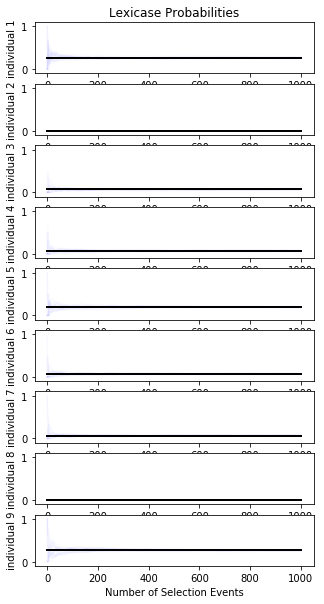

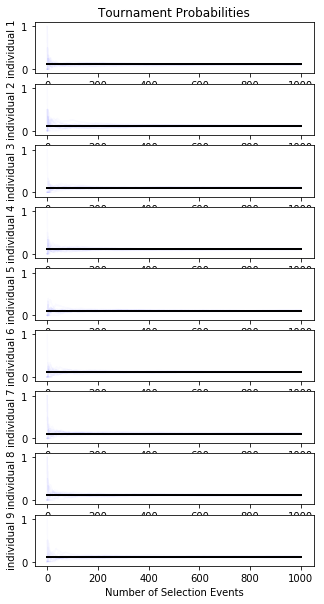

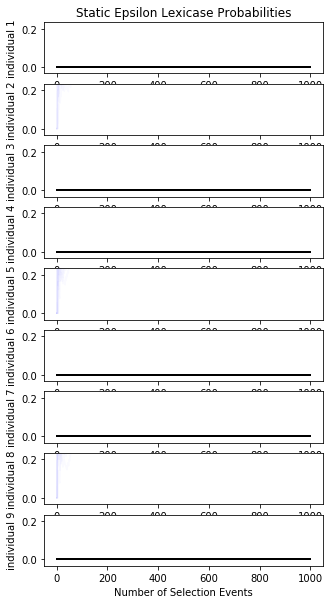

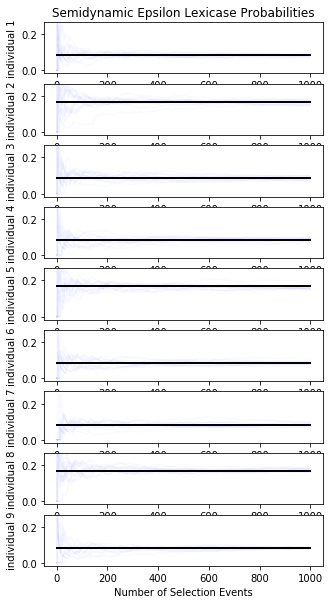

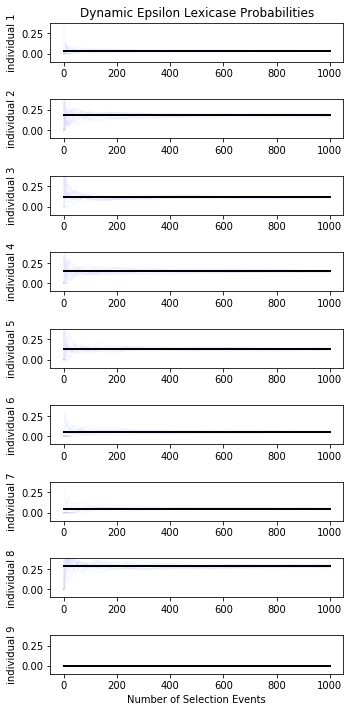

In [287]:
"""calculate convergence of tournament and lexicase selection on the ideal probabilities"""
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 50.0)
from tqdm import tqdm
#define population
P = 9
pop = []
for i in range(P):
    pop.append(ind(i))
# lee's paper
# pop[0].fit = np.array([2, 2, 4, 2])
# pop[1].fit = np.array([1, 2, 4, 3])
# pop[2].fit = np.array([2, 2, 3, 4])
# pop[3].fit = np.array([0, 2, 5, 5])
# pop[4].fit = np.array([0, 3, 5, 2])
# my example
pop[0].fit = np.array([0.0, 1.1, 2.2, 0, 8])
pop[1].fit = np.array([0.1, 1.2, 2.0, 1, 7])
pop[2].fit = np.array([0.2, 1.0, 2.1, 2, 6])
pop[3].fit = np.array([1.0, 2.1, 0.2, 3, 5])
pop[4].fit = np.array([1.1, 2.2, 0.0, 4, 4])
pop[5].fit = np.array([1.2, 2.0, 0.1, 5, 3])
pop[6].fit = np.array([2.0, 0.1, 1.2, 6, 2])
pop[7].fit = np.array([2.1, 0.2, 1.0, 7, 1])
pop[8].fit = np.array([2.2, 0.0, 1.1, 8, 0])

#cases
T = range(len(pop[0].fit))

# get analytic probabilities
P_lex = []
P_tourn = []
P_eplex_static = []
P_eplex_semi = []
P_eplex_dyn = []
# static ep lex pop conversion
pop2 = ep_convert(copy.deepcopy(pop))

for i,(p,p2) in enumerate(zip(pop,pop2)):

    P_lex.append(lex_prob(pop,T,p))
    
    P_tourn.append(tourn_prob(pop,p,2))
    
    P_eplex_static.append(lex_prob(pop2,T,p2))
    
    P_eplex_semi.append(ep_lex_prob(pop,T,p,get_eps(pop)))

    P_eplex_dyn.append(ep_lex_prob(pop,T,p,get_eps(pop),dynamic=True))
    
# print('P_eplex',P_eplex)
# estimate probabilities
h,ax = plt.subplots(P,figsize=(5,10))
h2,ax2 = plt.subplots(P,figsize=(5,10))
h3,ax3 = plt.subplots(P,figsize=(5,10))
h4,ax4 = plt.subplots(P,figsize=(5,10))
h5,ax5 = plt.subplots(P,figsize=(5,20))

its = 100
al = 2/its
for n in tqdm(np.arange(its)):
    num_selections = 1000
    
    P_lex_est = np.zeros((num_selections,P))
    P_tourn_est = np.zeros((num_selections,P))
    P_eplex_static_est = np.zeros((num_selections,P))
    P_eplex_semi_est = np.zeros((num_selections,P))
    P_eplex_dyn_est = np.zeros((num_selections,P))


    for s in np.arange(num_selections):
        if s>0:
            P_lex_est[s,:] = P_lex_est[s-1,:]
            P_tourn_est[s,:] = P_tourn_est[s-1,:]
            P_eplex_static_est[s,:] = P_eplex_static_est[s-1,:]
            P_eplex_semi_est[s,:] = P_eplex_semi_est[s-1,:]
            P_eplex_dyn_est[s,:] = P_eplex_dyn_est[s-1,:]
            
        P_lex_est[s,lexicase_selection(pop,T)] += 1/num_selections
        P_tourn_est[s,tournament_selection(pop,2)] += 1/num_selections
        P_eplex_static_est[s,lexicase_selection(pop2,T)] += 1/num_selections
        P_eplex_semi_est[s,epsilon_lexicase_selection(pop,T)] += 1/num_selections
        P_eplex_dyn_est[s,epsilon_lexicase_selection(pop,T,dynamic=True)] += 1/num_selections
        
    # normalize results
    for s in np.arange(num_selections):    
        P_lex_est[s,:] = P_lex_est[s,:]/np.sum(P_lex_est[s,:]) 
        P_tourn_est[s,:] = P_tourn_est[s,:]/np.sum(P_tourn_est[s,:]) 
        P_eplex_static_est[s,:] = P_eplex_static_est[s,:]/np.sum(P_eplex_static_est[s,:]) 
        P_eplex_semi_est[s,:] = P_eplex_semi_est[s,:]/np.sum(P_eplex_semi_est[s,:]) 
        P_eplex_dyn_est[s,:] = P_eplex_dyn_est[s,:]/np.sum(P_eplex_dyn_est[s,:]) 
        
    
    # plot results
   
    
    # Lexicase
    for i in np.arange(P_lex_est.shape[1]):

        ax[i].plot(np.arange(P_lex_est.shape[0]),P_lex_est[:,i],'b',alpha=al)
        ax[i].plot((0,num_selections),(P_lex[i],P_lex[i]),'k')
        ax[i].set_ylabel('individual '+str(i+1))
        ax[i].set_xlabel('Number of Selection Events')
        ax[i].set_ylim(-0.1,1.1)       
    
    ax[0].set_title('Lexicase Probabilities')
    plt.tight_layout()
    
    # Tournament
    for i in np.arange(P_tourn_est.shape[1]):

        ax2[i].plot(np.arange(P_tourn_est.shape[0]),P_tourn_est[:,i],'b',alpha=al)
        ax2[i].plot((0,num_selections),(P_tourn[i],P_tourn[i]),'k')
        ax2[i].set_ylabel('individual '+str(i+1))
        ax2[i].set_xlabel('Number of Selection Events')
        ax2[i].set_ylim(-0.1,1.1)
        
    ax2[0].set_title('Tournament Probabilities')
    plt.tight_layout()

    # Static Epsilon lexicase 
    for i in np.arange(P_eplex_static_est.shape[1]):

        ax3[i].plot(np.arange(P_eplex_static_est.shape[0]),P_eplex_static_est[:,i],'b',alpha=al)
        ax3[i].plot((0,num_selections),(P_eplex_static[i],P_eplex_static[i]),'k')
        ax3[i].set_ylabel('individual '+str(i+1))
        ax3[i].set_ylim(-0.1+np.min(P_eplex),np.max(P_eplex)+.1)
        
    ax3[-1].set_xlabel('Number of Selection Events')
    ax3[0].set_title('Static Epsilon Lexicase Probabilities')
    plt.tight_layout()
    
    # Semidynamic Epsilon lexicase 
    for i in np.arange(P_eplex_semi_est.shape[1]):

        ax4[i].plot(np.arange(P_eplex_semi_est.shape[0]),P_eplex_semi_est[:,i],'b',alpha=al)
        ax4[i].plot((0,num_selections),(P_eplex_semi[i],P_eplex_semi[i]),'k')
        ax4[i].set_ylabel('individual '+str(i+1))
        ax4[i].set_ylim(-0.1+np.min(P_eplex_semi),np.max(P_eplex_semi)+.1)
        
    ax4[-1].set_xlabel('Number of Selection Events')
    ax4[0].set_title('Semidynamic Epsilon Lexicase Probabilities')
    plt.tight_layout()

    # Dynamic Epsilon lexicase 
    for i in np.arange(P_eplex_dyn_est.shape[1]):

        ax5[i].plot(np.arange(P_eplex_dyn_est.shape[0]),P_eplex_dyn_est[:,i],'b',alpha=al)
        ax5[i].plot((0,num_selections),(P_eplex_dyn[i],P_eplex_dyn[i]),'k')
        ax5[i].set_ylabel('individual '+str(i+1))
        ax5[i].set_ylim(-0.1+np.min(P_eplex_dyn),np.max(P_eplex_dyn)+.1)
        
    ax5[-1].set_xlabel('Number of Selection Events')
    ax5[0].set_title('Dynamic Epsilon Lexicase Probabilities')
    plt.tight_layout()
    

# # print results
# print('final estimates')
# print('Sel','|','Actual','|','Estimate',sep='\n')
# print('tourn','|',P_tourn,'|',P_tourn_est[-1],sep='\n')
# print('lex','|',P_lex,'|',P_lex_est[-1],sep='\n')
# print('ep-lex','|',P_eplex,'|',P_eplex_est[-1],sep='\n')
h.savefig('lexicase_probability_convergence_' + str(num_selections) + 'selections.pdf')
h2.savefig('tournament_probability_convergence_' + str(num_selections) + 'selections.pdf')
h3.savefig('eplex_static_probability_convergence_' + str(num_selections) + 'selections.pdf')
h4.savefig('eplex_semi_probability_convergence_' + str(num_selections) + 'selections.pdf')
h5.savefig('eplex_dyn_probability_convergence_' + str(num_selections) + 'selections.pdf')
#png
h.savefig('lexicase_probability_convergence_' + str(num_selections) + 'selections.png')
h2.savefig('tournament_probability_convergence_' + str(num_selections) + 'selections.png')
h3.savefig('eplex_static_probability_convergence_' + str(num_selections) + 'selections.png')
h4.savefig('eplex_semi_probability_convergence_' + str(num_selections) + 'selections.png')
h5.savefig('eplex_dyn_probability_convergence_' + str(num_selections) + 'selections.png')










plt.show()

